In [1]:
#get all the sessions and their parameter
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from own_Functions import *
from scipy.ndimage import gaussian_filter as smooth
import scipy.stats as stats
import matplotlib.patches as mpatches

#problems remaining : how to treat the missing values in turnsinfo ?
#                     I don't have the phase of the session


list_mouse_number = ["MOU4087", "MOU4088","MOU4176", "MOU4177", "MOU4178", "MOU3871", "MOU3867"]
folder_path = "/localdata/alicedata/"
MetaData = pd.DataFrame({}) ; size_off_data = 0 #dataframe which will contain every infos of TXY
Meta_turn = pd.DataFrame({}) ; size_off_turns = 0 #dataframe which will contain every info of turnsinfo


#intialize the value of some variable
#define some important global variable
MINIMAL_DURATION_STOP = 0.1 #if a stop is shorter than this, fusionne the two epochs bordering it
MINIMAL_DURATION_EPOCH = 0.3 #minimal duration of an epoch to be considerd
TRAPEZE_SIZE = 35 # how much to extend outside of the objects to detect the trajectories
Resolution = 512,512 # variable which store the size of the experimental field in pixel
sigma_gauss  = 1 # the sigma used for the remaining of the analysis
true_cut_speed = 7 #value to be used for the remaining of the analysis
true_ecart_angle = 1 # if a change is made, must change timeofframes

#define the coordinate of the patches
NWpatch_coords = [[109, Resolution[1] -  130], [188, Resolution[1] -  130], [188, Resolution[1] -  215], [109, Resolution[1] -  215]]
NEpatch_coords = [[320, Resolution[1] -  130], [400, Resolution[1] -  130], [400, Resolution[1] -  210], [320, Resolution[1] -  210]]
SWpatch_coords = [[112, Resolution[1] -  344], [191, Resolution[1] -  344], [191, Resolution[1] -  410], [112, Resolution[1] -  410]]
SEpatch_coords = [[315, Resolution[1] -  350], [395, Resolution[1] -  350], [395, Resolution[1] -  415], [315, Resolution[1] -  415]]



#define the list of trapeze as a dictionnary containing  dictionnary to access them more easly
collection_trapeze = {"NW" : dict(), "NE" : dict(), "SW" : dict(), "SE" : dict()}
collection_trapeze["NW"]["N"], collection_trapeze["NW"]["E"], collection_trapeze["NW"]["S"], collection_trapeze["NW"]["W"] = trapezes_from_patch(NWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["NE"]["N"], collection_trapeze["NE"]["E"], collection_trapeze["NE"]["S"], collection_trapeze["NE"]["W"] = trapezes_from_patch(NEpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SW"]["N"], collection_trapeze["SW"]["E"], collection_trapeze["SW"]["S"], collection_trapeze["SW"]["W"] = trapezes_from_patch(SWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SE"]["N"], collection_trapeze["SE"]["E"], collection_trapeze["SE"]["S"], collection_trapeze["SE"]["W"] = trapezes_from_patch(SEpatch_coords, TRAPEZE_SIZE)


sessionFolders = {}
Meta_session_infos = {} #creat a dictionnary for each mouse
Meta_list_epoch = {}
for a in list_mouse_number : 
    Meta_session_infos[a] = pd.DataFrame({})
    Meta_list_epoch[a] = {}
    





#creation of the dataframes wich contain the infirmations for every session
for mouse in list_mouse_number : 
    mouseFolder_Path = folder_path + mouse
    os.chdir(mouseFolder_Path)
    sessionFolders[mouse]=[name for name in os.listdir(mouseFolder_Path) if os.path.isdir(os.path.join(mouseFolder_Path, name)) and name[0:3]=="MOU"]
    sessionFolders[mouse].sort()

    sessionParams = []
    for a in range(len(sessionFolders[mouse])) :
        session = sessionFolders[mouse][a]
        #get the TXY datas and clean it
        try : 
            df=pd.read_csv(mouseFolder_Path + "/" + session + "/" + session + "_centroidTXY.csv")# get the TXY file
            df=df.dropna() #supprime les lignes avec un ou plusieurs NA
            df=df.loc[df['time'] >15] # il y a des artefacts sur les premieres secondes de videos, donc il faut les supprimer
        except : continue
        df=df[df['xposition'].between(1,500) & df['yposition'].between(1,500)] #on garde les valeurs entre 15 et 500 (le tableau est cree plus grand que necessaire)

        df['xposition'] = smooth(df['xposition'].to_numpy(), sigma= sigma_gauss)#smooth the trajectory in x
        df['yposition'] = smooth(Resolution[1] - df['yposition'].to_numpy(), sigma= sigma_gauss) # smooth the trajectory in y and inverse the axis

        sizedf = len(df)
        df['session'] = [session] * sizedf #add column with the session to the dataframe
        #change the index of df to be compatible with metadata
        df['index'] = list(range(size_off_data, size_off_data + sizedf))
        df = df.set_index('index')

        MetaData = pd.concat([MetaData, df])#add the data of df at the end of metadata
        

        ######################################################

        #get the turnsinfo data
        dfturns = pd.read_csv(mouseFolder_Path + "/" + session + "/" + session + "_turnsinfo.csv")# get the TXY file
        dfturns=dfturns.loc[dfturns['time'] >15] # il y a des artefacts sur les premieres secondes de videos, donc il faut les supprimer

        sizedf_turn = len(dfturns)
        dfturns['session'] = [session] * sizedf_turn #add column with the session to the dataframe
        #change the index of df to be compatible with metadata
        dfturns['index'] = list(range(size_off_turns, size_off_turns + sizedf_turn))
        dfturns =  dfturns.set_index('index')

        Meta_turn = pd.concat([Meta_turn, dfturns])

        #####################################################

        session_infos = pd.read_csv(mouseFolder_Path + "/" + session + "/" + session + "_sessionparam.csv")

        #detect the type of phase
        try :
            if not session_infos.loc[session_infos.index[0], "Rewarded"] : phase = 0 #if no reward can be given, then it's the free exploration
            elif session_infos.loc[session_infos.index[0], "number_of_alternativeObject"] == 1 : phase = 4 #if only one alternative is available for the objects at a given time in the session, it's session 4 
            elif session_infos.loc[session_infos.index[0], "number_of_alternativeObject"] == 3 : phase = 3 #then it's phase 3
            elif session_infos.loc[session_infos.index[0], "potentialRewardedDirections"] == '[90, 270]' : phase = 1
            else : phase = 2
        except :
            phase = -1

        #add some informations to the session info. See below for details
        #session_infos += [phase, size_off_data, size_off_data + sizedf, size_off_turns, size_off_turns + sizedf_turn]
        session_infos["phase"] = [phase] ; session_infos["startPosition"] = [size_off_data] ; session_infos["endPosition"] = [size_off_data + sizedf]
        session_infos["startTurns"] = [size_off_turns] ; session_infos["endTurns"] = [size_off_turns + sizedf_turn]
        if a>0 and sessionFolders[mouse][a-1][8:16] == session [8:16] : #if the day of the session is the same as the previous session, it's the afternoon. every other case is considerd morning
            session_infos["timeOfDay"] = ["A"]# "A" for afternoon
        else : 
            session_infos["timeOfDay"] = ["M"]# "M" for morning

        session_infos["session"] = session
        Meta_session_infos[mouse] = pd.concat([Meta_session_infos[mouse], session_infos])


        size_off_data += sizedf ; size_off_turns += sizedf_turn

    Meta_session_infos[mouse].set_index("session", inplace = True)


MetaData['distance'] = np.zeros(size_off_data)
MetaData['speed'] = np.zeros(size_off_data)
MetaData['timeAverage'] = np.zeros(size_off_data)
MetaData['acceleration'] = np.zeros(size_off_data)
MetaData['direction'] = np.zeros(size_off_data)
MetaData['angularSpeed'] = np.zeros(size_off_data)


for mouse in list_mouse_number :
    for session in Meta_session_infos[mouse].index :

        start_data = Meta_session_infos[mouse].loc[session, "startPosition"]#get the start and end indice for the session (on the metadata dataframe)
        end_data = Meta_session_infos[mouse].loc[session, "endPosition"]

        #this function does the analysis of the session then store the informations corresponding in Metadata + List_epoch
        MetaData.loc[MetaData.index[start_data: end_data], 'distance'], MetaData.loc[MetaData.index[start_data: end_data], 'speed'], MetaData.loc[MetaData.index[start_data: end_data], 'timeAverage'], MetaData.loc[MetaData.index[start_data: end_data], 'acceleration'], MetaData.loc[ MetaData.index[start_data: end_data], 'direction'], MetaData.loc[ MetaData.index[start_data: end_data], 'angularSpeed'], list_epoch = analysis_trajectory(time = MetaData['time'][start_data: end_data].to_numpy(),
                            xgauss= MetaData['xposition'][start_data: end_data].to_numpy(), 
                            ygauss= MetaData['yposition'][start_data: end_data].to_numpy(), collection_trapeze= collection_trapeze, 
                            dinfo=Meta_turn[Meta_session_infos[mouse].loc[session, "startTurns"]: Meta_session_infos[mouse].loc[session, "endTurns"]], cut_speed= true_cut_speed, 
                            ecart_angle= true_ecart_angle, Resolution= Resolution, MIN_DURATION_STOP= MINIMAL_DURATION_STOP, MIN_DURATION_EPOCH= MINIMAL_DURATION_EPOCH)
        
        Meta_list_epoch[mouse][session] = [[epoch[0] + start_data, epoch[1]+start_data, epoch[2]] for epoch in list_epoch]


#meta_session_infos[mouse][session] is of the form 
# [experimentater name (0), mouse number (1), duration of experiment (2),  (3) hour of the  injection CNO under the form HHMM, none if no injection today
# , potentialy rewarded direction (4), potentially rewarded object (5), number of aletrnative object (6), direction fot the next object as a string (7)  
# , range max consec rewards (8), is early exploration allowed (9), rewards are available (10)
# , number of the phase (11), beginning indice in metadata (12), end indice in metadata (13), start indice in meta_turn (14), end indice in meta_turn (15), time of day (16)]


#way to build the dataframes : 

# creation of the dictionnary, one entry per mouse

# loop on all mouse
#     loop on all session of the mouse
#         get the dataframe TXY
#         clean the data of the dataframe
#         add a column indicating which session it is 
#         change the index of the dataframe to be the following part of the metadataframe, store the index  of beginning and of end of the session

#         get the dataframe turnsinfo
#         repeat the same set as for the XTY dataframe, but save it in a MetaTurn

#         get the informations of the session, add the index of the session in the metadateframe (beginning and end) and the CNO if necessary
#         add the informations as a list to a dictionnary containing the informations on every session and using them as key
# 

fonction permettant de suivre une variable à travers les sessions 

instructions to creat the function : 
compute the variable values for the current session

entry (in that order) : - the part of Metadata corresponding to the current session (pandas dataframe)
                        - list_epoch for the current session (list)

output : list of tha values taken by the variable during the session 

format of MetaData : (int) index number of the row in the full dataframe    "index"
        
        - column 0 = (float) time since the beginning of the session         "time"
        - column 1 = (float) detected position of the mouse along the X axis    "xposition"
        - column 2 = (float) detected position of the mouse along the Y axis    "yposition"
        - column 3 = (string) session name - should be the same in every line of a given call   "session"
        - column 4 = (float) DISTANCE done between the position of the previous line and the current one. First value at 0      "distance"
        - column 5 = (float) SPEED between the previous line and the current one. First value at 0                              "speed"
        - column 6 = (float) timeAverage between the previous line and the cuirrent one, used to get the time corresponding to the value demanding multiple point. First value as time[0]    "timeAverage"

        - column 7 = (float, relative) ACCELERATION derivate of speed by time. First two values must be ignored       "acceleration"
        - column 8 = (float, [-180, 180]) ORIENTATION angle done between the movement vector of the mouse and the X axis. First value at 0      "direction"
        - column 9 = (float, relative) ANGULAR SPEED derivate of orientation by time    "angularSpeed"


format of list_epoch :

        - indice 0 = line of MetaData where the epoch start
        - indice 1 = last line of Metadata for the epoch (included)
        - indice 2 = epoch indicator  (the format after the first element will depend of the trajectory type)
                        
            ~ [0] = "N" for others (exploratotive trajectory)
            ~ [0] = 'B' for BETWEEN OBJECT    [1 - 2] = previous patch    [3-4] = current patch
                    # [5] = 'n'/'r' for non-rewarded/ rewarded (if multiple turns are done in the movement, only the last one is considered)
            ~ [0] = 'Q' for QUARTER TURN     [1] = 'k'/'w' for counterclockwise / clockwise   
                    # [2] = 'O'/'E'/'B'/'G'/'H' for wrong object /extra turn / bad direction / Good / double wrong             
                    # [3-4] = patch             [5] = 'R'/'N' for rewarded/non-rewarded
            ~ [0] = 'T' for TOWARD OBJECT    [1 - 2] = previous patch 

to get a precise cell in the Dataframe : df.loc[df.index[rowNumber], "columnName"]

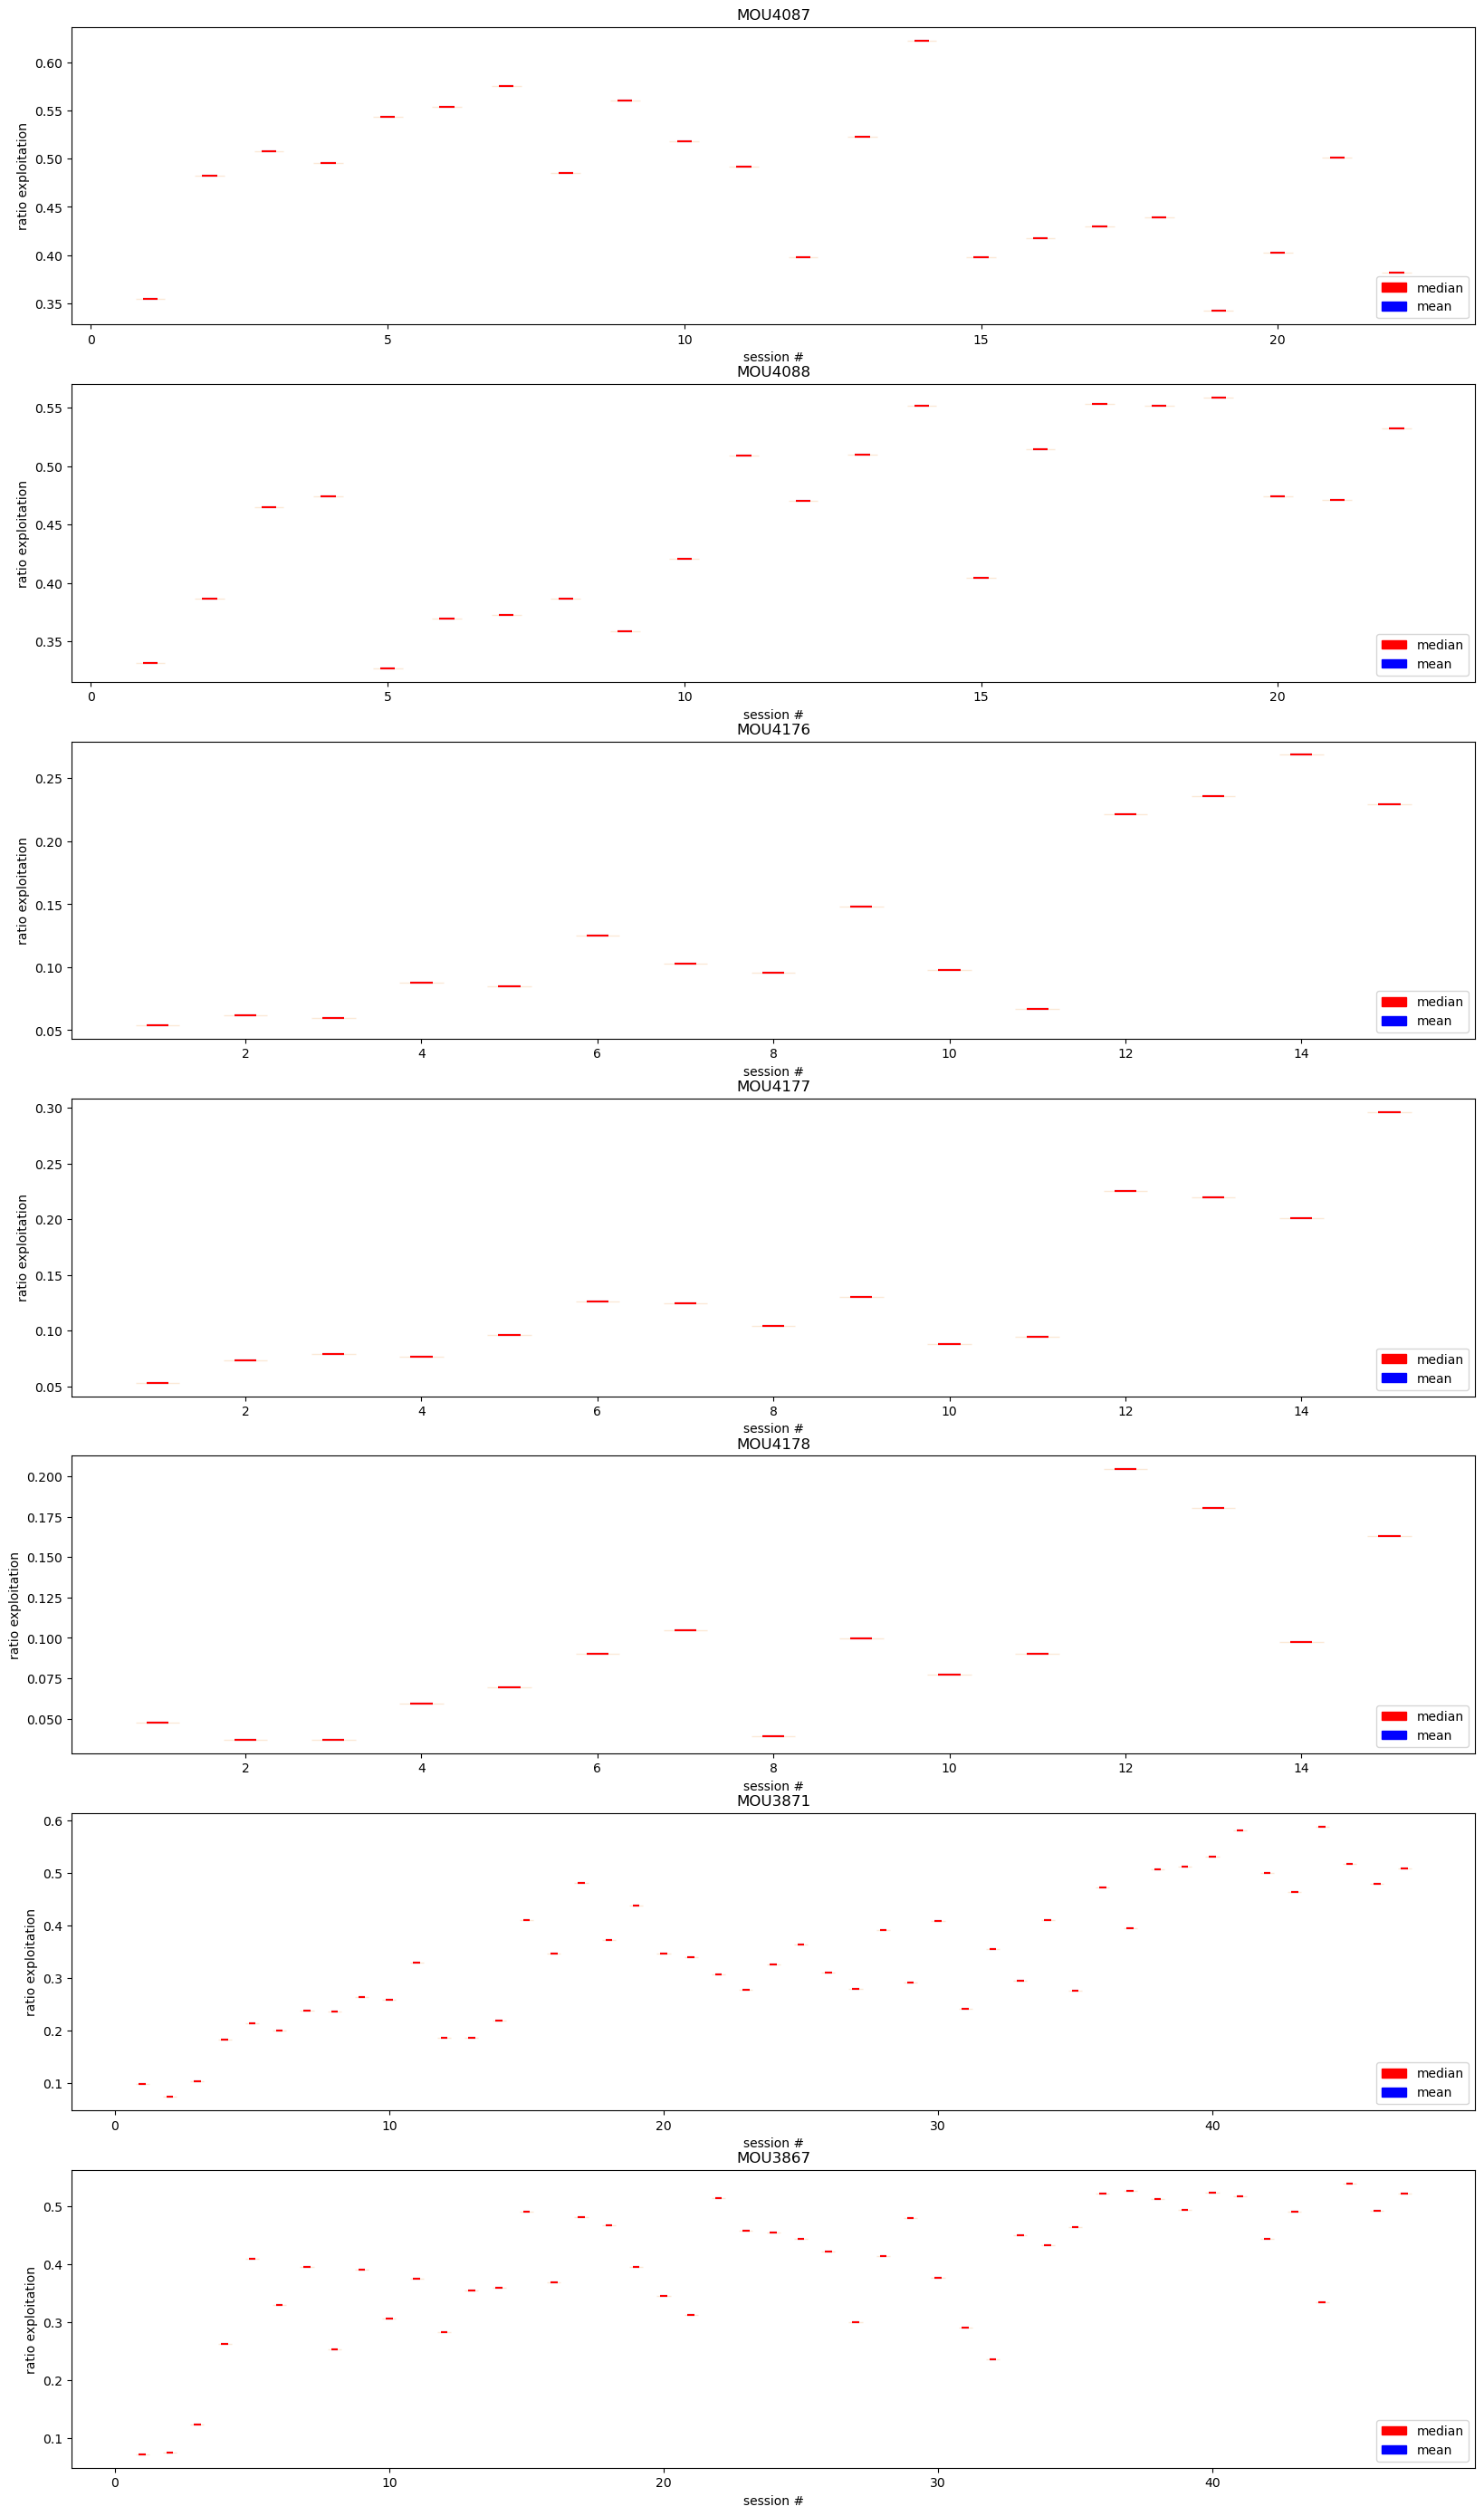

In [17]:
def suiviVariable(fonction_variable, liste_souris, metaData, meta_list_epoch, meta_session_info, output_type = "violin", variableName = ""):
    """
    function which show the evolution of the result of the 'fonction_variable' across the different sessions for every mouse

    fonction_variable : function which take in entry the part of MetaData corresponding to the session then the list_epoch for the session and give back the variable for the session under the form of a list of values
    liste_souris : (list of string) list of the mouse numbers which need to be printed. All mouse cited here must have been treated in the first cell
    metaData : the dataframe MetaData obtained in the first cell
    meta_list_epoch : the dataframe Meta_list_epoch obtained in the first cell
    meta_session_info : the dictionnary of dataframes Meta_session_info obtained in the first cell
    output_type : (string) which type of graph must be plotted. Currently supported : 'violin'
    variableName : (string) the name given of the y axis
    """


    
    resultats = {} # creat the dictionnary which will hold the result of the function calls
    for souris in liste_souris : resultats[souris] = []
    nb_line = len(liste_souris)

    for souris in liste_souris : 
        for session in meta_session_info[souris].index : #loop on each session for each mouse

            start_data = meta_session_info[souris].loc[session, "startPosition"]#get the start and end indice for the session (on the metadata dataframe)
            end_data = meta_session_info[souris].loc[session, "endPosition"]
            liste_epoch = [[epoch[0] - start_data, epoch[1] - start_data, epoch[2]] for epoch in meta_list_epoch[souris][session]] #get the correct indice on the epoch for a reduce dataframe

            resultats[souris].append(fonction_variable(metaData.loc[metaData.index[start_data: end_data]], liste_epoch, meta_session_info[souris].loc[session])) #actual function call
    
    #####################################################################
    #start of the graphs printing

    #define the color Palette
    phasePalette = ['#fbabd2', # 'Other' : pink
                    '#b4a7d6', # 'Phase1': purple
                    '#94ccff', # 'Phase2': blue
                    '#84d567', # 'Phase3': green
                    '#f5b779'] # 'Phase4': orange
    
    if output_type == "violin" :
        plt.figure(figsize=(20, 5 * nb_line)) #setup the dimension of the result

        for a in range(nb_line): #loop on each mouse to print their results 
            plt.subplot(nb_line, 1, a+1) #select the corresponding subplot

            infos = plt.violinplot(resultats[liste_souris[a]], showmedians= True, showextrema= False, showmeans= True)#creat the violinplot

            phases = [Meta_session_infos[liste_souris[a]].loc[session, "phase"] for session in meta_list_epoch[liste_souris[a]].keys()] # get the phase of each session

            i = 0 #color each phase in a diferent color
            # cmap = plt.get_cmap("Dark2")             
            for part in infos['bodies']  : 
                part.set_facecolor(phasePalette[phases[i]])
                part.set_edgecolor(phasePalette[phases[i]])
                
                i += 1

            #color the mean and the median, as well as prepare the legend to indicate them
            infos['cmedians'].set_color( ["red"] * len(infos['bodies'])) ; median_legend = mpatches.Patch(color = "red", label = "median") 
            infos['cmeans'].set_color(["blue"]  * len(infos['bodies'])) ; mean_legend = mpatches.Patch(color = "blue", label = "mean")
            
            plt.xlabel("session #")
            plt.ylabel(variableName)
            plt.legend(handles = [median_legend, mean_legend], loc = 4)
            plt.title(liste_souris[a])
        plt.show()
        return
    # elif output_type == "boxplot" : 
    # elif output_type == "median" : #the default is the median curve
    else : 
        raise ValueError("graph type not recognized")


def speedDuringEpoch(df, list_epoch, session_info):
    speeds = [df.loc[df.index[indice], 'speed']  for epoch in list_epoch for indice in range(epoch[0], epoch[1] + 1)] #get every instantanious speed during an epoch
    no_extreme_list = [speedy for speedy in np.sort(speeds)[int(len(speeds) * 0.1) : int(len(speeds) * 0.9)]] # take out the lowest 10% and the top 10%
    return no_extreme_list #return the speed wihout the extremes values

def ratioTimeExploiting(df, list_epoch, session_info) : 
    duration = [df.loc[df.index[epoch[1]], 'time'] - df.loc[df.index[epoch[0]], 'time'] for epoch in list_epoch if epoch[2][0] == "Q" or epoch[2][0] == "B"]
    total_time = sum(duration)
    return [total_time / df.loc[df.index[-1], 'time']]


suiviVariable(liste_souris= list_mouse_number, metaData= MetaData, fonction_variable= ratioTimeExploiting, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, variableName= "ratio exploitation")

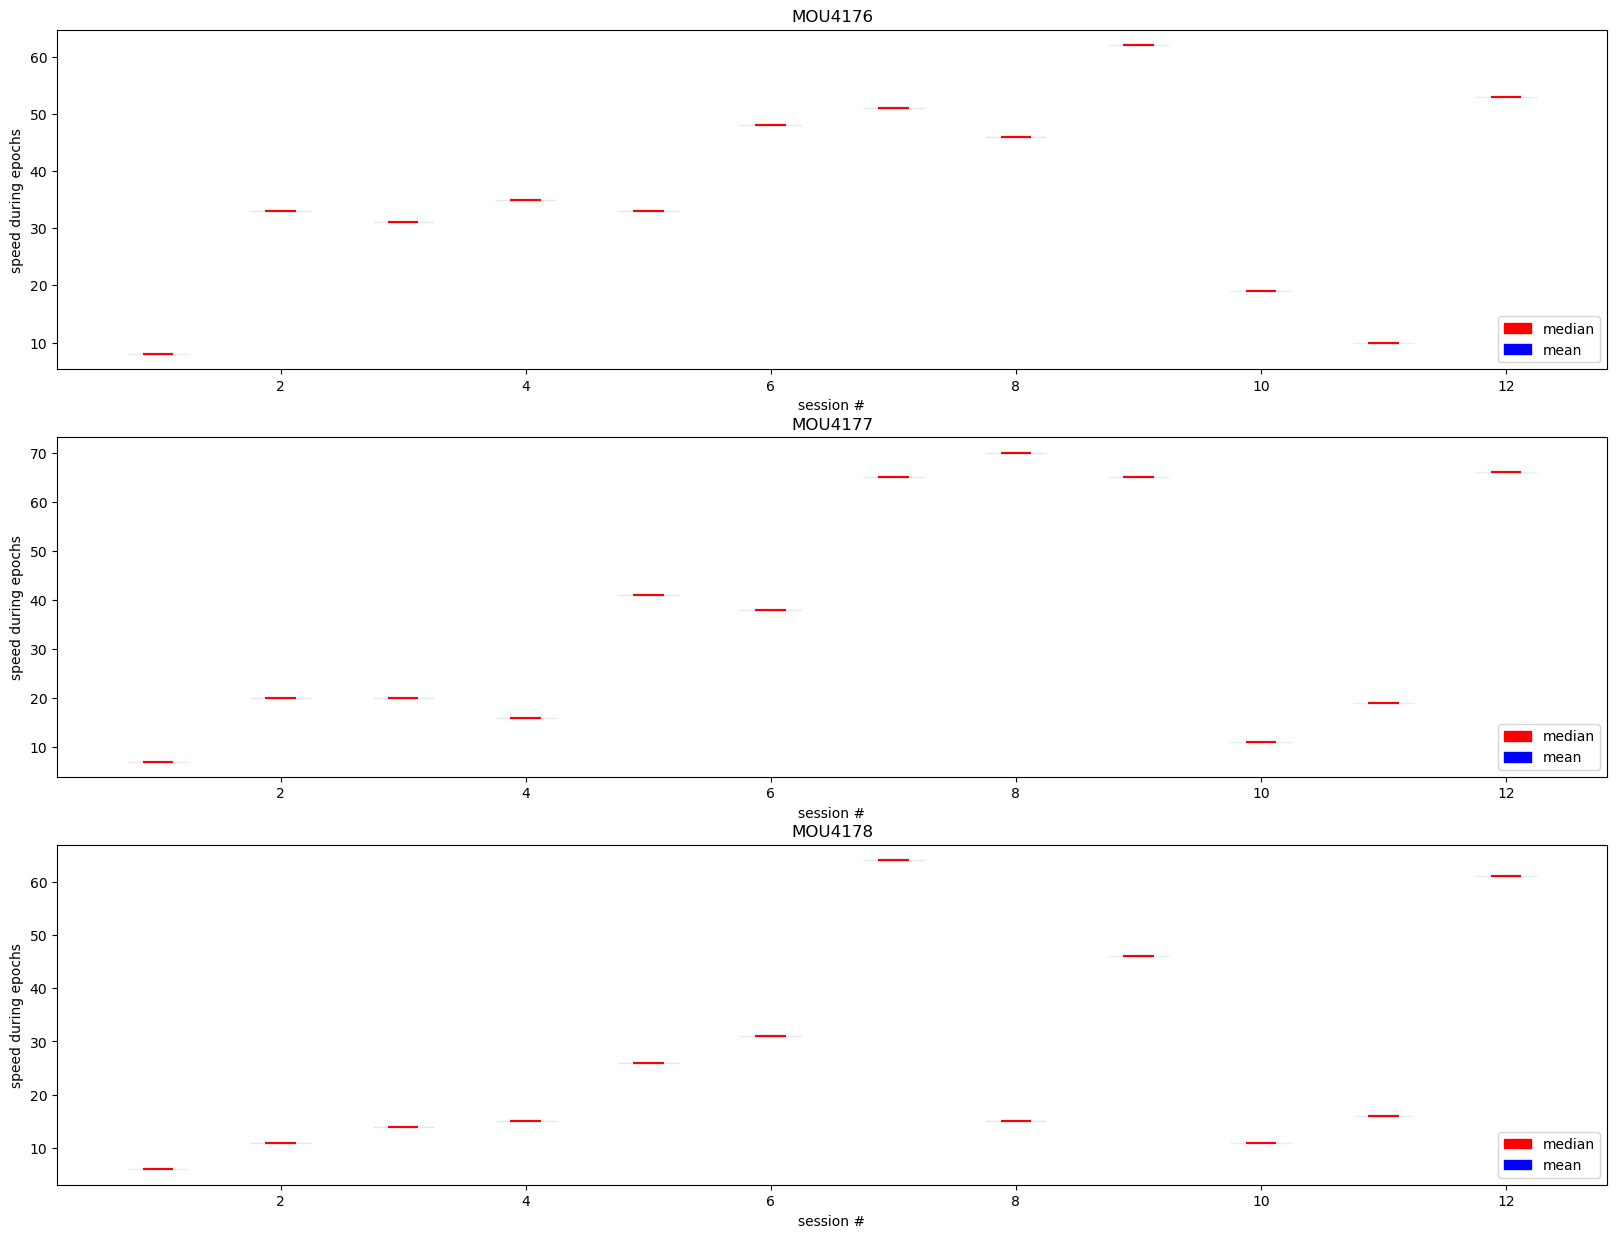

In [3]:
def cherchequarttourrecompense(df, list_epoch, session_infos):
    total_quart_recomp =0

    for epoch in list_epoch : 
        if epoch[2][0] == "Q" and epoch[2][2] == "G" : 
            total_quart_recomp += 1 
    return [total_quart_recomp]

suiviVariable(liste_souris= list_mouse_number, metaData= MetaData, fonction_variable= cherchequarttourrecompense, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, variableName= "speed during epochs")

In [10]:
#tests en tout genre
Meta_session_infos[mouse].set_index("session", inplace = True)
print(Meta_session_infos[mouse].index)

Index(['MOU4087_20230612-1140', 'MOU4087_20230612-1640',
       'MOU4087_20230613-1102', 'MOU4087_20230613-1631',
       'MOU4087_20230619-1047', 'MOU4087_20230619-1607',
       'MOU4087_20230620-1017', 'MOU4087_20230620-1544',
       'MOU4087_20230621-1051', 'MOU4087_20230621-1620',
       'MOU4087_20230622-1032', 'MOU4087_20230622-1422',
       'MOU4087_20230623-1031', 'MOU4087_20230623-1422',
       'MOU4087_20230627-0951', 'MOU4087_20230627-1625',
       'MOU4087_20230628-0953', 'MOU4087_20230628-1539',
       'MOU4087_20230629-0950', 'MOU4087_20230629-1626',
       'MOU4087_20230630-0947', 'MOU4087_20230630-1555'],
      dtype='object', name='session')
